<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/SelfAwareAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
### Network with LSTM memorty memory

### Sensor encoder and SelfAwareAgent

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SensorEncoder(nn.Module):
    def __init__(self, num_sensors, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(num_sensors, hidden_dim, batch_first=True)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4)

    def forward(self, x):
        # x shape: (batch, sequence_length, num_sensors)
        encoded, _ = self.lstm(x)
        # Prepare for attention: (sequence_length, batch, hidden_dim)
        encoded = encoded.transpose(0, 1)
        attended, _ = self.attention(encoded, encoded, encoded)
        # Return to (batch, sequence_length, hidden_dim)
        attended = attended.transpose(0, 1)
        return attended

class InternalStatePredictor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.state_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, current_state, action_embedding):
        combined = torch.cat([current_state, action_embedding], dim=-1)
        next_state = self.state_predictor(combined)
        return next_state

class RewardPredictor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action_embedding):
        combined = torch.cat([state, action_embedding], dim=-1)
        predicted_reward = self.predictor(combined)
        return predicted_reward

class SelfAwareAgent(nn.Module):
    def __init__(self, num_sensors, hidden_dim=128):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Sensor processing
        self.sensor_encoder = SensorEncoder(num_sensors, hidden_dim)

        # Action embeddings (up/down)
        self.action_embedding = nn.Embedding(2, hidden_dim)

        # Internal state prediction
        self.state_predictor = InternalStatePredictor(hidden_dim)

        # Reward prediction
        self.reward_predictor = RewardPredictor(hidden_dim)

        # Action selector - taking last timestep's hidden state
        self.action_selector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Binary output for up/down
        )

        # Self-awareness components
        self.prediction_error_history = []
        self.confidence_threshold = 0.8

    def compute_prediction_confidence(self):
        if len(self.prediction_error_history) < 10:
            return 0.5
        recent_errors = torch.tensor(self.prediction_error_history[-10:])
        return torch.exp(-recent_errors.mean()).item()

    def forward(self, sensor_sequence, training=True):
        # Encode sensor inputs
        encoded_state = self.sensor_encoder(sensor_sequence)  # (batch, seq_len, hidden_dim)
        current_state = encoded_state[:, -1]  # Take last timestep (batch, hidden_dim)

        # Generate action probabilities
        action_logits = self.action_selector(current_state)
        action_probs = F.softmax(action_logits, dim=-1)

        if training:
            # Sample action during training
            action = torch.multinomial(action_probs, 1)
        else:
            # Take most confident action during evaluation
            action = action_probs.argmax(dim=-1, keepdim=True)

        # Get action embedding
        action_embed = self.action_embedding(action).squeeze(1)

        # Predict next state and reward
        predicted_next_state = self.state_predictor(current_state, action_embed)
        predicted_reward = self.reward_predictor(current_state, action_embed)

        # Compute prediction confidence
        confidence = self.compute_prediction_confidence()

        return {
            'action': action,
            'action_probs': action_probs,
            'predicted_next_state': predicted_next_state,
            'predicted_reward': predicted_reward,
            'confidence': confidence
        }

    def update_self_awareness(self, predicted_reward, actual_reward):
        prediction_error = abs(predicted_reward - actual_reward)
        self.prediction_error_history.append(prediction_error)

        # Adjust confidence threshold based on prediction performance
        if len(self.prediction_error_history) >= 100:
            recent_performance = torch.tensor(self.prediction_error_history[-100:]).mean()
            self.confidence_threshold = max(0.5, min(0.9, 1.0 - recent_performance))

    def train_step(self, sensor_sequence, action_taken, received_reward):
        outputs = self.forward(sensor_sequence)

        # Convert scalar reward to tensor
        reward_tensor = torch.tensor(received_reward, dtype=torch.float32).view(-1, 1)

        # Compute losses
        reward_prediction_loss = F.mse_loss(
            outputs['predicted_reward'],
            reward_tensor
        )

        action_loss = F.cross_entropy(
            outputs['action_probs'],
            torch.tensor([action_taken], dtype=torch.long)
        )

        # Update self-awareness metrics
        self.update_self_awareness(
            outputs['predicted_reward'].item(),
            received_reward
        )

        total_loss = reward_prediction_loss + action_loss
        return total_loss, outputs['confidence']

### Create scenarios

In [28]:
import numpy as np
import torch
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class TrainingScenario:
    name: str
    difficulty: str
    pattern_length: int
    noise_level: float

class SensorEnvironment:
    def __init__(self, num_sensors: int, sequence_length: int):
        self.num_sensors = num_sensors
        self.sequence_length = sequence_length
        self.current_step = 0
        self.current_pattern = None
        self.pattern_reward_map = None

    def generate_pattern(self, pattern_length: int) -> np.ndarray:
        """Generate a new pattern that determines rewards"""
        return np.random.choice([-1, 1], size=(pattern_length, self.num_sensors))

    def initialize_scenario(self, scenario: TrainingScenario):
        """Set up environment for a new training scenario"""
        self.current_pattern = self.generate_pattern(scenario.pattern_length)
        self.noise_level = scenario.noise_level
        self.current_step = 0

        # Create reward mapping for the pattern
        self.pattern_reward_map = {}
        for i in range(len(self.current_pattern)):
            # Positive reward if action matches dominant signal direction
            correct_action = 1 if np.mean(self.current_pattern[i]) > 0 else 0
            self.pattern_reward_map[i] = correct_action

    def get_sensor_data(self) -> torch.Tensor:
        """Get current sensor readings with noise"""
        start_idx = self.current_step % len(self.current_pattern)
        pattern_segment = self.current_pattern[start_idx:start_idx + self.sequence_length]

        # Add noise
        noise = np.random.normal(0, self.noise_level, pattern_segment.shape)
        noisy_data = pattern_segment + noise

        return torch.FloatTensor(noisy_data).unsqueeze(0)  # Add batch dimension

    def step(self, action: int) -> Tuple[float, bool]:
        """Take a step in the environment and return reward"""
        current_idx = self.current_step % len(self.current_pattern)
        correct_action = self.pattern_reward_map[current_idx]

        # Calculate reward
        reward = 1.0 if action == correct_action else -0.5

        self.current_step += 1
        done = self.current_step >= 1000  # Episode length limit

        return reward, done

def create_training_scenarios() -> List[TrainingScenario]:
    """Create a progression of training scenarios"""
    return [
        TrainingScenario("Basic", "Easy", 4, 0.1),
        TrainingScenario("Noisy", "Medium", 4, 0.3),
        TrainingScenario("Complex", "Hard", 8, 0.2),
        TrainingScenario("Challenge", "Very Hard", 8, 0.4)
    ]

def train_episode(agent, env: SensorEnvironment, optimizer, scenario: TrainingScenario) -> dict:
    """Run one training episode"""
    env.initialize_scenario(scenario)
    episode_rewards = []
    episode_confidences = []
    episode_pred_errors = []

    done = False
    while not done:
        # Get current sensor data
        sensor_data = env.get_sensor_data()

        # Agent selects action
        outputs = agent(sensor_data, training=True)
        action = outputs['action'].item()

        # Environment step
        reward, done = env.step(action)

        # Train agent
        loss, confidence = agent.train_step(sensor_data, action, reward)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record metrics
        episode_rewards.append(reward)
        episode_confidences.append(outputs['confidence'])
        episode_pred_errors.append(abs(outputs['predicted_reward'].item() - reward))

    return {
        'rewards': episode_rewards,
        'confidences': episode_confidences,
        'pred_errors': episode_pred_errors,
        'total_reward': sum(episode_rewards),
        'avg_confidence': np.mean(episode_confidences),
        'avg_pred_error': np.mean(episode_pred_errors)
    }

def evaluate_agent(agent, env: SensorEnvironment, scenario: TrainingScenario, num_episodes: int = 10) -> dict:
    """Evaluate agent performance"""
    eval_metrics = []

    for _ in range(num_episodes):
        env.initialize_scenario(scenario)
        episode_rewards = []
        episode_confidences = []

        done = False
        while not done:
            with torch.no_grad():
                sensor_data = env.get_sensor_data()
                outputs = agent(sensor_data, training=False)
                action = outputs['action'].item()
                reward, done = env.step(action)

                episode_rewards.append(reward)
                episode_confidences.append(outputs['confidence'])

        eval_metrics.append({
            'total_reward': sum(episode_rewards),
            'avg_confidence': np.mean(episode_confidences)
        })

    return {
        'avg_total_reward': np.mean([m['total_reward'] for m in eval_metrics]),
        'avg_confidence': np.mean([m['avg_confidence'] for m in eval_metrics])
    }

### Combined Scenario Monitor

In [29]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from collections import defaultdict
import time

class CombinedScenariosMonitor:
    def __init__(self, history_length=100):
        self.history_length = history_length
        # Store metrics separately for each scenario
        self.scenario_metrics = defaultdict(lambda: {
            'rewards': [],
            'confidences': [],
            'pred_errors': [],
            'episodes': []
        })
        self.current_episode = 0
        self.scenario_colors = {
            'Basic': '#1f77b4',    # Blue
            'Noisy': '#ff7f0e',    # Orange
            'Complex': '#2ca02c',   # Green
            'Challenge': '#d62728'  # Red
        }

    def update(self, metrics, scenario_name):
        """Update metrics for specific scenario"""
        scenario_data = self.scenario_metrics[scenario_name]
        scenario_data['rewards'].append(metrics['total_reward'])
        scenario_data['confidences'].append(metrics['avg_confidence'])
        scenario_data['pred_errors'].append(metrics['avg_pred_error'])
        scenario_data['episodes'].append(self.current_episode)
        self.current_episode += 1

    def plot_metrics(self):
        """Plot metrics for all scenarios on same graphs"""
        clear_output(wait=True)

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

        # Plot for each scenario
        for scenario_name, metrics in self.scenario_metrics.items():
            color = self.scenario_colors[scenario_name]
            episodes = metrics['episodes']

            if not episodes:  # Skip if no data
                continue

            # Reward plot
            ax1.plot(episodes, metrics['rewards'],
                    color=color, label=f'{scenario_name}',
                    alpha=0.7, linewidth=2)

            # Add trend line for rewards
            if len(episodes) > 1:
                z = np.polyfit(episodes, metrics['rewards'], 1)
                p = np.poly1d(z)
                ax1.plot(episodes, p(episodes),
                        color=color, linestyle='--', alpha=0.3)

            # Confidence plot
            ax2.plot(episodes, metrics['confidences'],
                    color=color, label=f'{scenario_name}',
                    alpha=0.7, linewidth=2)

            # Prediction Error plot
            ax3.plot(episodes, metrics['pred_errors'],
                    color=color, label=f'{scenario_name}',
                    alpha=0.7, linewidth=2)

        # Configure plots
        ax1.set_title('Training Metrics Across Scenarios')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        ax2.set_ylabel('Average Confidence')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Avg Prediction Error')
        ax3.grid(True, alpha=0.3)
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Print current metrics for each scenario
        print("\nCurrent Metrics:")
        for scenario_name, metrics in self.scenario_metrics.items():
            if metrics['rewards']:  # If scenario has data
                print(f"\n{scenario_name}:")
                print(f"Latest Reward: {metrics['rewards'][-1]:.2f}")
                print(f"Latest Confidence: {metrics['confidences'][-1]:.2f}")
                print(f"Latest Pred Error: {metrics['pred_errors'][-1]:.2f}")


### Train Agent and combine all scenarios in one plot

In [30]:
def train_with_combined_monitoring():
    # Initialize components
    num_sensors = 5
    sequence_length = 10
    env = SensorEnvironment(num_sensors, sequence_length)
    agent = SelfAwareAgent(num_sensors)
    optimizer = torch.optim.Adam(agent.parameters(), lr=0.001)
    monitor = CombinedScenariosMonitor()

    # Get training scenarios
    scenarios = create_training_scenarios()

    # Training loop
    for scenario in scenarios:
        print(f"\nStarting scenario: {scenario.name}")

        for episode in range(1000):
            # Train episode
            metrics = train_episode(agent, env, optimizer, scenario)

            # Update monitor with scenario name
            monitor.update(metrics, scenario.name)

            # Update visualization every 10 episodes
            if episode % 10 == 0:
                monitor.plot_metrics()
                time.sleep(0.1)  # Small delay to prevent overwhelming Colab

            # Check for scenario completion
            if metrics['avg_confidence'] > 0.8 and metrics['total_reward'] > 800:
                print(f"\nCompleted scenario {scenario.name}")
                monitor.plot_metrics()  # Final plot for this scenario
                break

# Example usage:
"""
monitor = CombinedScenariosMonitor()
train_with_combined_monitoring()
"""

'\nmonitor = CombinedScenariosMonitor()\ntrain_with_combined_monitoring()\n'

### Create monitor instance and train agent on all scenarios

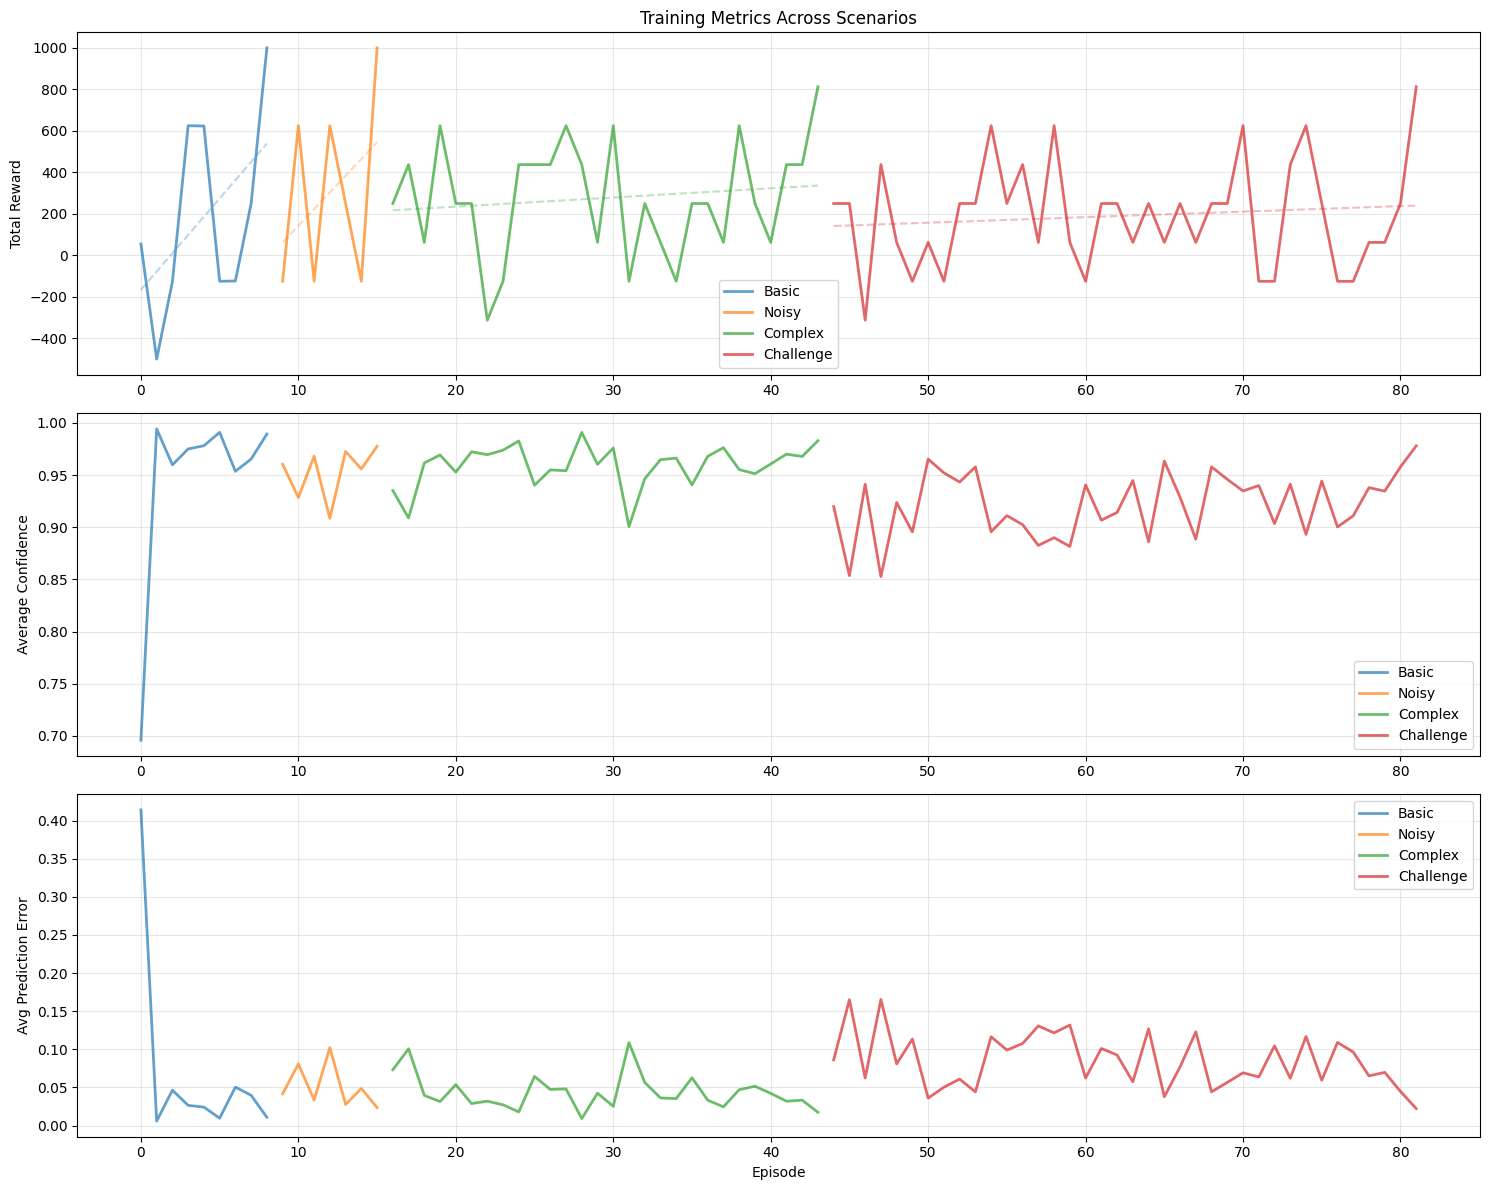


Current Metrics:

Basic:
Latest Reward: 1000.00
Latest Confidence: 0.99
Latest Pred Error: 0.01

Noisy:
Latest Reward: 1000.00
Latest Confidence: 0.98
Latest Pred Error: 0.02

Complex:
Latest Reward: 812.50
Latest Confidence: 0.98
Latest Pred Error: 0.02

Challenge:
Latest Reward: 812.50
Latest Confidence: 0.98
Latest Pred Error: 0.02


In [31]:
monitor = CombinedScenariosMonitor()
train_with_combined_monitoring()